In [1]:
# Importando bibliotecas
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.max_colwidth=500
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
!pip install transformers[torch]
!pip install datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from datasets import Value, ClassLabel, Features, DatasetDict

In [2]:
!pip install accelerate[torch]

In [3]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download 'marlesson/news-of-the-site-folhauol'
!unzip -qq news-of-the-site-folhauol.zip
!rm news-of-the-site-folhauol.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/marlesson/news-of-the-site-folhauol
License(s): CC0-1.0
 98% 184M/187M [00:09<00:00, 22.9MB/s]
100% 187M/187M [00:09<00:00, 20.6MB/s]


In [4]:
# Carregando o dataset
df=pd.read_csv("articles.csv",encoding="utf8")
df.head(2)

,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem força como cabo eleitoral","Com a possibilidade de uma condenação impedir sua candidatura em 2018, o ex-presidente Luiz Inácio Lula da Silva fez, nesta segunda (9), um discurso inflamado contra a Lava Jato, no qual disse saber que está ""lascado"", exigiu um pedido de desculpas do juiz Sergio Moro e afirmou que, mesmo fora da disputa pelo Planalto, será um cabo eleitoral expressivo para a sucessão de Michel Temer. Segundo o petista, réu em sete ações penais, o objetivo de Moro é impedir sua candidatura no ano que vem, d...",2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/1925743-lula-diz-que-esta-lascado-mas-que-ainda-tem-forca-como-cabo-eleitoral.shtml
1,"'Decidi ser escrava das mulheres que sofrem', diz cantora Oumou Sangaré","Para Oumou Sangaré, cantora e ativista malinesa, o sofrimento da mulher é universal. ""Canto com todas as minhas forças e vejo mulheres chorando ao meu redor"", disse durante um encontro na Casa da Cultura de Paraty, no Rio de Janeiro, neste domingo (8). Herdeira da tradição musical de sua família –sua avó foi uma ""grande estrela"" do país africano–, ela conta que começou a cantar na rua para ajudar nas finanças de casa após o divórcio dos pais, que deixou seis filhos dependentes de sua mãe, t...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10/1925745-decidi-ser-escrava-das-mulheres-que-sofrem-diz-cantora-oumou-sangare.shtml


In [5]:
# Ajustando o dataset
df.drop_duplicates(subset=["text"],inplace=True)
df.drop(['title','subcategory','link','date'],axis=1,inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.head()
print(df.shape)

(165901, 2)


In [6]:
# Pegando as 7 categorias mais comuns no dataset
category_counts = df['category'].value_counts()
print(category_counts)
top_seven_categories = category_counts.head(7)
class_names = top_seven_categories.index
df = df[df['category'].isin(class_names)]
df.shape

category
poder                           22005
colunas                         21499
mercado                         20936
esporte                         19723
mundo                           17123
cotidiano                       16952
ilustrada                       15604
opiniao                          4523
paineldoleitor                   4008
saopaulo                         3953
tec                              2205
educacao                         2113
tv                               2065
turismo                          1902
ilustrissima                     1377
ciencia                          1331
equilibrioesaude                 1311
sobretudo                        1052
bbc                               979
folhinha                          875
empreendedorsocial                841
comida                            828
asmais                            547
ambiente                          490
seminariosfolha                   378
serafina                          331
o-m

(133842, 2)

In [7]:
# Substituir as categorias por números em todo o DataFrame
labels, class_names = pd.factorize(df['category'],sort=True)
class_names = list(class_names.values)
df['labels'] = labels
print(class_names)

['colunas', 'cotidiano', 'esporte', 'ilustrada', 'mercado', 'mundo', 'poder']


<ipython-input-7-8b990b023855>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['labels'] = labels


In [8]:
# Dividir o DataFrame em treinamento e teste
train, test = train_test_split(df[['text','labels']].sample(n=10000), test_size=0.2, random_state=42)
features = Features({"text": Value("string"),"labels": ClassLabel(names=class_names)})
print('features =',features)

dataset = DatasetDict({
    "train": Dataset.from_pandas(train, preserve_index=False),
    "test": Dataset.from_pandas(test, preserve_index=False)
    })

print('dataset =',dataset)
print("dataset['train'].features =",dataset['train'].features)

features = {'text': Value(dtype='string', id=None), 'labels': ClassLabel(names=['colunas', 'cotidiano', 'esporte', 'ilustrada', 'mercado', 'mundo', 'poder'], id=None)}
dataset = DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 2000
    })
})
dataset['train'].features = {'text': Value(dtype='string', id=None), 'labels': Value(dtype='int64', id=None)}


In [9]:
# Carrega um modelo e tokenizer pré-treinado
model_name = 'neuralmind/bert-base-portuguese-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer(dataset['train'][7]['text'])
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=7)  # 7 classes de saída

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Função para tokenizar os textos
max_length = 512

def preprocess_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=max_length)

In [11]:
# Tokeniza os dados
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [12]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
training_args = TrainingArguments(
    output_dir="my__model",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
)


# Train the model
trainer.train()

# Save the trained model
trainer.save_model('model')

Epoch,Training Loss,Validation Loss
1,0.502500,0.318376
2,0.181000,0.325082
3,0.073000,0.335959


In [14]:
# Avalia o modelo
trainer.evaluate()

{'eval_loss': 0.33595919609069824,
 'eval_runtime': 56.4991,
 'eval_samples_per_second': 35.399,
 'eval_steps_per_second': 2.212,
 'epoch': 3.0}

In [15]:
outputs = trainer.predict(tokenized_dataset['test'])

<Axes: >

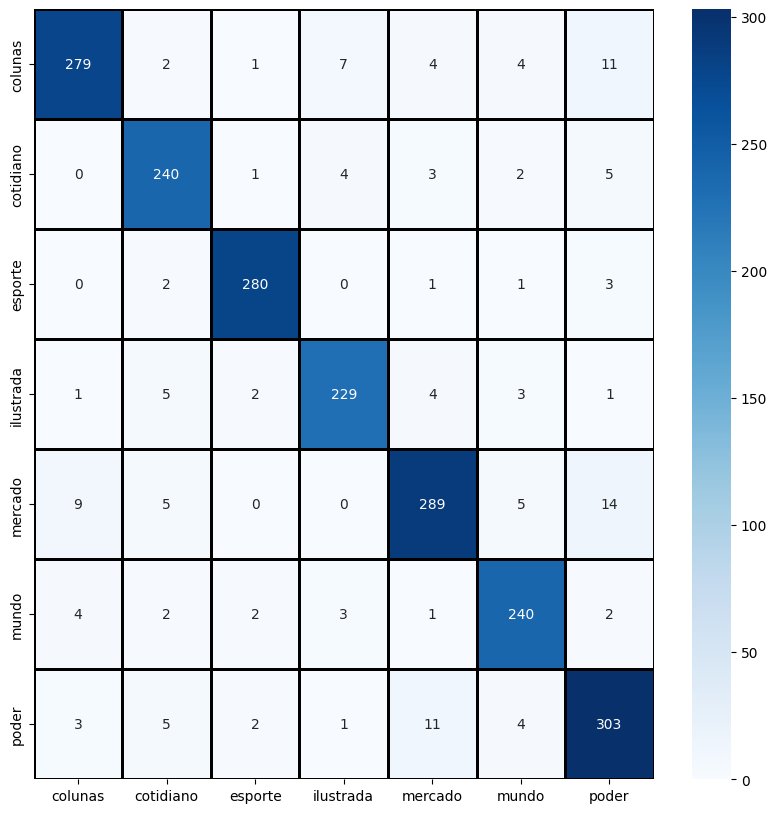

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm , index = class_names , columns = class_names)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = class_names , yticklabels = class_names)

In [18]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     colunas       0.94      0.91      0.92       308
   cotidiano       0.92      0.94      0.93       255
     esporte       0.97      0.98      0.97       287
   ilustrada       0.94      0.93      0.94       245
     mercado       0.92      0.90      0.91       322
       mundo       0.93      0.94      0.94       254
       poder       0.89      0.92      0.91       329

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000

